In [84]:
import math
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import powerlaw as pl
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score
from matplotlib.ticker import ScalarFormatter
from community import community_louvain

In [37]:
# change defaults to be less ugly
mpl.rc('xtick', labelsize=14, color="#222222") 
mpl.rc('ytick', labelsize=14, color="#222222") 
mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
mpl.rc('font', size=16)
mpl.rc('xtick.major', size=20, width=1)
mpl.rc('xtick.minor', size=5, width=1)
mpl.rc('ytick.major', size=6, width=1)
mpl.rc('ytick.minor', size=3, width=1)
mpl.rc('axes', linewidth=1, edgecolor="#222222", labelcolor="#222222")
mpl.rc('text', usetex=False, color="#222222")

special_sizes = [10**2, 10**3, 10**4]
colors = dict(zip(special_sizes, 'rgb'))
bins = dict(zip(special_sizes, [10, 20, 30]))

G_nonDev = nx.Graph()

### Often Reused Functions

Includes functions for graphing degree distribution, powerlaw fit, generating a Barbassi-Albert network using the preferential attachment model, function to calculate how close each generation of partitons in louvain are, and despine to remove the spines on the right and top sices of the graph and rearranging the ticks tot he x and y axis for a cleaner graph.

All but one of these functions originate from Professor Emma Towlsons code with only small modifications to the degree distributions to fit in weighted degree

In [38]:
def despine():
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

In [39]:
# BONUS MATERIAL: Simple use of the powerlaw package to fit the degree distributions. 

def plot_deg_dist_and_fit(G, bins, color, isweighted):
    deg = []
    if isweighted:
        deg = [G.degree(node, weight='weight') for node in G]
    else:
        deg = [val for (_, val) in G.degree()]
    
    kmin, kmax = min(deg), max(deg)

    if kmin == 0:
        be = np.logspace(kmin, np.log10(kmax), bins) # logarithms of bin edges
    else:
        be = np.logspace(np.log10(kmin), np.log10(kmax), bins) # logarithms of bin edges
    
    logbe = np.log10(be)
    # "x" values should be midway through each bin (in log space)
    x = 10**((logbe[1:] + logbe[:-1])/2)
    # plot empirical data
    p, _ = np.histogram(deg, bins=be, density=True)
    plt.loglog(x, p, color=color, linestyle='none', marker='o', alpha=0.65,
               markeredgecolor='none')
    # plot theoretical fit. Here we define xmin and xmax, but the powerlaw package can determine the best choices of xmin and xmax for real data
    fit = pl.Fit(deg, xmin=min(deg), xmax=max(deg)) # look at whole range (w/o min and max powerlaw finds best for us)
    print('gamma= ',fit.power_law.alpha) # we say gamma, powerlaw pkg says alpha
    fit.power_law.plot_pdf(color=color)

In [40]:
def plot_deg_dist(G, bins, color, isweighted):
    deg = []
    if isweighted:
        deg = [G.degree(node, weight='weight') for node in G]
    else:
        deg = [val for (_, val) in G.degree()]
    
    print(deg)

    kmin, kmax = min(deg), max(deg)

    if kmin == 0:
        be = np.logspace(kmin, np.log10(kmax), bins) # logarithms of bin edges
    else:
        be = np.logspace(np.log10(kmin), np.log10(kmax), bins) # logarithms of bin edges
    
    logbe = np.log10(be)
    # "x" values should be midway through each bin (in log space)
    x = 10**((logbe[1:] + logbe[:-1])/2)
    # plot empirical data
    p, _ = np.histogram(deg, bins=be, density=True)
    plt.loglog(x, p, color=color, linestyle='none', marker='o', alpha=0.65,
               markeredgecolor='none')
    fit = pl.Fit(deg, xmin=min(deg), xmax=max(deg))

In [41]:
def ba(n, m):
    G = nx.complete_graph(m)
    for new_node in range(m, n):
        deg = [val for (node, val) in G.degree()]
        p = np.array(deg)
        p = p/sum(p)
        nbrs = np.random.choice(G, size=m, p=p, replace=False)
        G.add_edges_from([(new_node, nbr) for nbr in nbrs])
        # do this as an iterator so we can look at every step of the process 
        yield G # Iterator w/o recalculating

In [80]:
def stability_testing(G, num_runs=1000):
    # Store detected communities for each run
    community_assignments = []

    # Perform multiple runs of Louvain method
    for _ in tqdm(range(num_runs)):
        # Run Louvain method to detect communities
        partition = community_louvain.best_partition(G)
        community_assignments.append(partition)

    # Compute stability matrix
    stability_matrix = []
    for i in tqdm(range(num_runs)):
        row = []
        for j in range(num_runs):
            # Compute Adjusted Rand Index between community assignments
            ari = adjusted_rand_score(list(community_assignments[i].values()), 
                                      list(community_assignments[j].values()))
            row.append(ari)
        stability_matrix.append(row)

    avg = 0
    divide_by = 0
    for row in stability_matrix:
        for i in row:
            avg += i
        divide_by += len(row)

    result = avg / float(divide_by)

    return result

In [55]:
def largest_5_communities(partition):
    seen_communities = {}
    # Print the community assignments for each node
    for _, community_id in partition.items():
        if community_id in seen_communities:
            seen_communities[community_id] += 1
        else:
            seen_communities[community_id] = 1

    top_seen = dict(sorted(seen_communities.items(), key=lambda item: item[1], reverse=True))

    return list(top_seen.keys())[:5]


### Loading the Network from the edge list and dnoe list

In [78]:
with open('Project_Data/nonDevDepNodeList.csv', 'r') as file:
    for line in file:
        id, label, dependencies = line.strip().split('\t')
        
        deps = dependencies.split(",")
        deps = [x for x in deps if (']' and '[') not in x]
        deps = [x.replace('"', '') for x in deps]
        deps = [x.replace("'", '') for x in deps]
        deps = [x.replace(" ", '') for x in deps]
        deps = [x.replace("]", '') for x in deps]
        G_nonDev.add_node(id, label=label, dependencies=deps)

with open('Project_Data/nonDevDepEdgeList.csv', 'r') as file:
    next(file)

    for line in file:
        source, target, weight, label = line.strip().split('\t')

        deps = label.split(",")
        # deps = [x for x in deps if ('}' and '{') not in x]
        deps = [x.replace('"', '') for x in deps]
        deps = [x.replace("'", '') for x in deps]
        deps = [x.replace(" ", '') for x in deps]
        deps = [x.replace("}", '') for x in deps]
        deps = [x.replace("{", '') for x in deps]

        G_nonDev.add_edge(source, target)

        # print(f'{source}, {target}, {weight}, {deps}')
        G_nonDev[source][target]['weight'] = float(weight)
        G_nonDev[source][target]['label'] = deps

# In the column header ID when we open it when reading the file 
# it gets mistakenly added as a node when I read the csv line by line
# in my above code so I just remove it here.
G_nonDev.remove_node('ID')

True


#### Obtain Small Statistics on Network

Such as the size of the network, number of edges, average degree, max degree, min degree, and clustering coefficient

In [44]:
N = len(G_nonDev)
L = G_nonDev.size()
degrees = [G_nonDev.degree(node) for node in G_nonDev]
kmin = min(degrees)
kmax = max(degrees)

degrees_weighted = [G_nonDev.degree(node, weight='weight') for node in G_nonDev]
weighted_kmin = min(degrees_weighted)
weighted_kmax = max(degrees_weighted)

print("Number of nodes: ", N)
print(f"Number of edges: {L}\n")

print("Average degree: ", 2*L/N)
print(f"Average degree (alternate calculation){np.mean(degrees)}\n")

print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

print("Minimum weighted degree: ", weighted_kmin)
print("Maximum weighted degree: ", weighted_kmax)

C_avg = np.mean(list(nx.clustering(G_nonDev).values()))
print("Clustering unweighted: ", C_avg)

Cw_avg = np.mean(list(nx.clustering(G_nonDev, weight='weight').values()))
print("Clustering weighted: ", Cw_avg)

# p value at which giant component (of size log(n) nodes) is expected
p_giant_nonDev = 1.0 / (N - 1)
# p value at which graph is expected to become completely connected
p_conn_nonDev = math.log(N) / N

# identify largest connected component | link: https://networkx.org/documentation/stable/auto_examples/graphviz_layout/plot_giant_component.html
Rcc_nonDev = sorted(nx.connected_components(G_nonDev), key=len, reverse=True)
Giant_nonDev = G_nonDev.subgraph(Rcc_nonDev[0])

print(f"Size of largest connected component: {len(Giant_nonDev)}")
print(f"Number of connected components: {len(Rcc_nonDev)}")

S_Avg_Path = nx.average_shortest_path_length(Giant_nonDev)

print("Shortest Path: ", S_Avg_Path)

Number of nodes:  5043
Number of edges: 24135

Average degree:  9.571683521713267
Average degree (alternate calculation)9.571683521713267

Minimum degree:  0
Maximum degree:  148
Minimum weighted degree:  0
Maximum weighted degree:  2.421520000000003
Clustering unweighted:  0.5641925323861352
Clustering eeighted:  0.004958052389515588
Size of largest connected component: 4834
Number of connected componentsL 95
Shortest Path:  4.050134226653897


### Degree Distribution for Unweighted

Values less than or equal to 0 in data. Throwing out 0 or negative values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0, 40, 22, 44, 8, 48, 5, 30, 3, 12, 7, 7, 13, 97, 8, 6, 8, 8, 142, 20, 21, 46, 47, 26, 20, 8, 8, 9, 118, 5, 18, 29, 15, 6, 7, 16, 8, 6, 15, 41, 68, 39, 16, 19, 13, 37, 8, 28, 8, 22, 8, 17, 9, 9, 13, 22, 127, 52, 33, 36, 17, 12, 9, 11, 22, 6, 13, 3, 18, 13, 6, 17, 81, 19, 63, 15, 12, 43, 23, 34, 18, 2, 31, 3, 36, 20, 6, 11, 1, 104, 13, 10, 26, 6, 14, 49, 14, 17, 12, 5, 32, 9, 6, 13, 15, 18, 46, 62, 8, 37, 38, 33, 10, 44, 12, 15, 14, 5, 7, 12, 3, 14, 10, 22, 61, 6, 9, 91, 3, 20, 16, 2, 21, 5, 22, 14, 6, 6, 35, 26, 3, 18, 3, 15, 3, 40, 37, 20, 1, 32, 15, 32, 11, 22, 6, 21, 8, 4, 12, 37, 4, 23, 1, 22, 2, 1, 16, 9, 90, 29, 16, 29, 22, 13, 56, 49, 1, 20, 6, 7, 5, 22, 5, 5, 26, 10, 69, 8, 58, 8, 11, 38, 16, 11, 10, 5, 15, 10, 5, 8, 6, 28, 9, 13, 24, 12, 7, 6, 21, 14, 22, 38, 23, 37, 2, 17, 31, 14, 64, 17, 79, 20, 13, 19, 17, 14, 29, 13, 28, 23, 6, 16, 27, 14, 27, 9, 27, 9, 20, 14, 19, 16, 7, 10, 32, 21, 6, 42, 18, 13, 6, 18, 23, 16, 7, 19, 47, 33, 17, 31, 18, 23, 17, 59, 24, 85, 2, 40, 1, 16

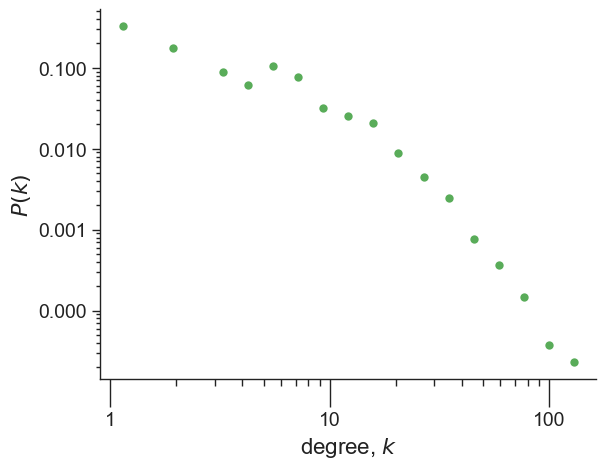

In [45]:
ax = plt.subplot(111)

plot_deg_dist(G_nonDev, bins[1000], colors[1000], False)
plt.legend(frameon=False, numpoints=1)
plt.xlabel(r"degree, $k$")
plt.ylabel(r"$P(k)$")
despine()

# Customize the tick formatter for the x and y axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))


plt.show()
# probably a scale free networks?

### Degree Distribution for Weighted

[0, 2.35147, 0.17963, 0.39052, 0.062479999999999994, 0.44519999999999993, 0.06248, 0.2655600000000001, 0.02343, 0.09371999999999998, 0.054669999999999996, 0.07029999999999999, 0.10152999999999998, 0.8434999999999991, 0.062479999999999994, 0.04686, 0.062479999999999994, 0.062479999999999994, 2.421520000000003, 0.1562, 0.16401000000000002, 0.5467499999999996, 0.4842599999999998, 0.37492000000000003, 0.17182000000000003, 0.062479999999999994, 0.062479999999999994, 0.07028999999999999, 2.218470000000006, 0.03905, 0.14057999999999998, 0.39835999999999977, 0.11714999999999998, 0.04686, 0.054669999999999996, 0.14057999999999998, 0.062479999999999994, 0.04686, 0.11714999999999998, 2.3045900000000032, 1.9529800000000002, 2.3124100000000025, 0.12495999999999997, 0.14839, 0.11714999999999999, 0.28897000000000006, 0.062479999999999994, 0.2421100000000001, 0.062479999999999994, 0.17182000000000003, 0.062479999999999994, 0.13276999999999997, 0.08591, 0.08591, 0.11714999999999998, 0.17963, 1.09340999

Values less than or equal to 0 in data. Throwing out 0 or negative values


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


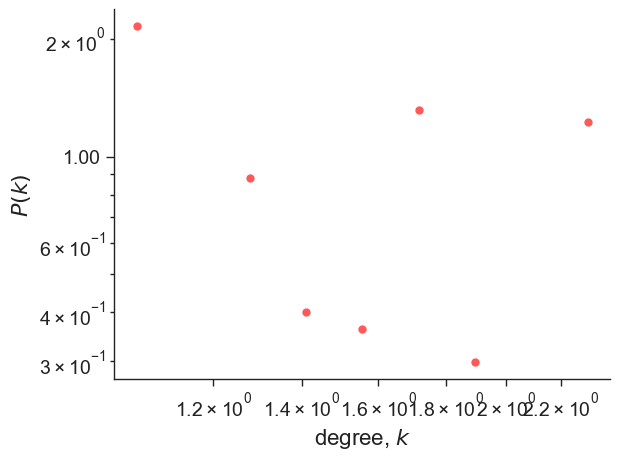

In [46]:
ax = plt.subplot(111)

plot_deg_dist(G_nonDev, bins[100], colors[100], True)
plt.legend(frameon=False, numpoints=1)
plt.xlabel(r"degree, $k$")
plt.ylabel(r"$P(k)$")
despine()

# Customize the tick formatter for the x and y axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))


plt.show()
# probably a scale free networks?

### Degree Distribution with Powerlaw Fit Unweighted

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


gamma=  3.845343579871427


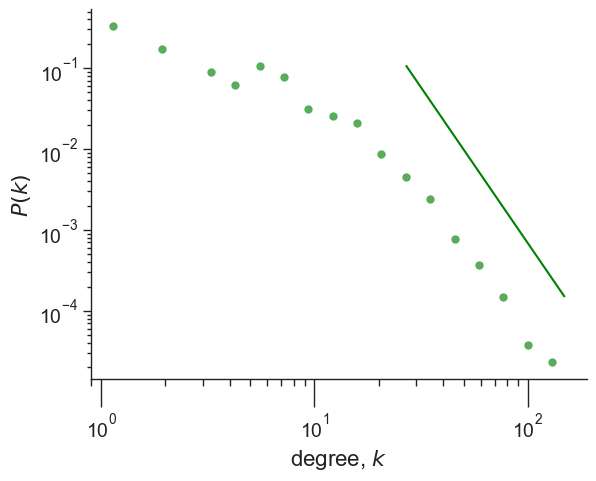

In [47]:
ax = plt.subplot(111)

plot_deg_dist_and_fit(G_nonDev, bins[1000], colors[1000], False)
plt.legend(frameon=False, numpoints=1)
plt.xlabel(r"degree, $k$")
plt.ylabel(r"$P(k)$")
despine()

### Degree Distribution with Powerlaw Fit Weighted

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


gamma=  3.1649749586464533


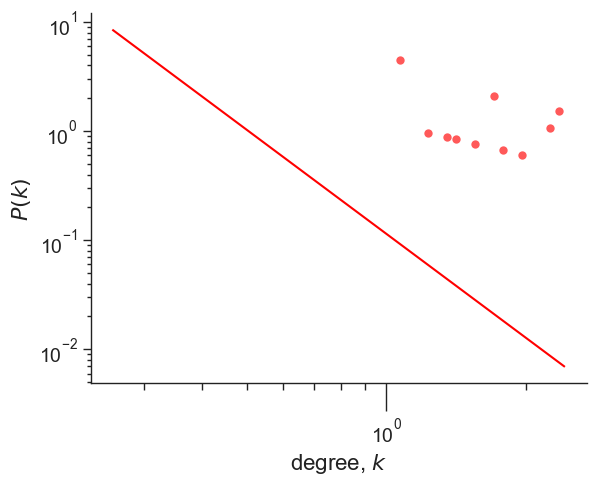

In [48]:
ax = plt.subplot(111)

plot_deg_dist_and_fit(G_nonDev, bins[1000], colors[100], True)
plt.legend(frameon=False, numpoints=1)
plt.xlabel(r"degree, $k$")
plt.ylabel(r"$P(k)$")
despine()

### Test stability of communities from whole network

In [49]:
Average_ARI = stability_testing(G_nonDev)
print(f"Average ARI: {Average_ARI}")

100%|██████████| 1000/1000 [17:30<00:00,  1.05s/it]

[[1.         0.27372233 0.29505436 ... 0.28788488 0.28090391 0.27565254]
 [0.27372233 1.         0.33225472 ... 0.30296218 0.26740248 0.30816163]
 [0.29505436 0.33225472 1.         ... 0.31916461 0.23242194 0.28558748]
 ...
 [0.28788488 0.30296218 0.31916461 ... 1.         0.29303867 0.30544863]
 [0.28090391 0.26740248 0.23242194 ... 0.29303867 1.         0.29988951]
 [0.27565254 0.30816163 0.28558748 ... 0.30544863 0.29988951 1.        ]]


### Grab Largest Communities

In [86]:
comp_nonDev = community_louvain.best_partition(G_nonDev)

comp_nonDev_weights = community_louvain.best_partition(G_nonDev, weight='weight')

In [87]:
df = pd.read_csv("Project_Data/nonDevDepNodeList.csv", delimiter="\t")


df_unweighted = df.copy(deep=True)
df_unweighted["community"] = df_unweighted["label"].map(comp_nonDev)
df_unweighted.to_csv("Project_Data/nonDevDepNodeListCommunityUnweighted.csv", index=False, sep='\t')


df_weighted = df.copy(deep=True)
df_weighted["community"] = df_weighted["label"].map(comp_nonDev_weights)
df_weighted.to_csv("Project_Data/nonDevDepNodeListCommunityUnweighted.csv", index=False, sep='\t')


Do note after generating one that I'm satisfied with I would write down the top 5 communities here since the ids may change during reruns: ["10", "33", "6", "23", "18"].

In [90]:
top_5_unweighted = largest_5_communities(comp_nonDev)

top_5_weighted = largest_5_communities(comp_nonDev_weights)

In [73]:
top_5_communities = ["10", "33", "6", "23", "18"]
with open('Used_in_Gephi/nonDevDepNodeListCommunityUnweighted.csv', 'r') as file:
    for line in file:
        id, label, dependencies, communities = line.strip().split('\t')

        deps = dependencies.split(",")
        deps = [x for x in deps if (']' and '[') not in x]
        deps = [x.replace('"', '') for x in deps]
        deps = [x.replace("'", '') for x in deps]
        deps = [x.replace(" ", '') for x in deps]
        deps = [x.replace("]", '') for x in deps]
        G_nonDev.add_node(id, label=label, dependencies=deps, communities=communities)

G_nonDev_top5 = nx.Graph()

for n in G_nonDev.nodes():
    if G_nonDev.nodes[n]["communities"] in top_5_communities:
        G_nonDev_top5.add_node(n, label=n, dependencies=G_nonDev.nodes[n]["dependencies"], communities=G_nonDev.nodes[n]["communities"])


with open('Project_Data/nonDevDepEdgeList.csv', 'r') as file:
    next(file)

    for line in file:
        source, target, weight, label = line.strip().split('\t')

    
        deps = label.split(",")
        # deps = [x for x in deps if ('}' and '{') not in x]
        deps = [x.replace('"', '') for x in deps]
        deps = [x.replace("'", '') for x in deps]
        deps = [x.replace(" ", '') for x in deps]
        deps = [x.replace("}", '') for x in deps]
        deps = [x.replace("{", '') for x in deps]

        if G_nonDev_top5.has_node(source) and G_nonDev_top5.has_node(target):

            G_nonDev_top5.add_edge(source, target)

            # print(f'{source}, {target}, {weight}, {deps}')
            G_nonDev_top5[source][target]['weight'] = float(weight)
            G_nonDev_top5[source][target]['label'] = deps

### Get General Stats for the Subgraph

Notice at this point I've decided to just look into the unweighted version of the network

In [76]:
N = len(G_nonDev_top5)
L = G_nonDev_top5.size()
degrees = [G_nonDev_top5.degree(node) for node in G_nonDev_top5]
kmin = min(degrees)
kmax = max(degrees)

degrees_weighted = [G_nonDev_top5.degree(node, weight='weight') for node in G_nonDev_top5]
weighted_kmin = min(degrees_weighted)
weighted_kmax = max(degrees_weighted)

print("Number of nodes: ", N)
print(f"Number of edges: {L}\n")

print("Average degree: ", 2*L/N)
print(f"Average degree (alternate calculation){np.mean(degrees)}\n")

print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

print("Minimum weighted degree: ", weighted_kmin)
print("Maximum weighted degree: ", weighted_kmax)

C_avg = np.mean(list(nx.clustering(G_nonDev_top5).values()))
print("Clustering unweighted: ", C_avg)

Cw_avg = np.mean(list(nx.clustering(G_nonDev_top5, weight='weight').values()))
print("Clustering weighted: ", Cw_avg)

# p value at which giant component (of size log(n) nodes) is expected
p_giant_nonDev = 1.0 / (N - 1)
# p value at which graph is expected to become completely connected
p_conn_nonDev = math.log(N) / N

# identify largest connected component | link: https://networkx.org/documentation/stable/auto_examples/graphviz_layout/plot_giant_component.html
Rcc_nonDev = sorted(nx.connected_components(G_nonDev_top5), key=len, reverse=True)
Giant_nonDev = G_nonDev_top5.subgraph(Rcc_nonDev[0])

print(f"Size of largest connected component: {len(Giant_nonDev)}")
print(f"Number of connected components: {len(Rcc_nonDev)}")

S_Avg_Path = nx.average_shortest_path_length(Giant_nonDev)

print("Shortest Path: ", S_Avg_Path)

Number of nodes:  1201
Number of edges: 3938

Average degree:  6.557868442964197
Average degree (alternate calculation)6.557868442964197

Minimum degree:  1
Maximum degree:  87
Minimum weighted degree:  0.00781
Maximum weighted degree:  0.8357099999999993
Clustering unweighted:  0.6020100166522692
Clustering eeighted:  0.020688844995623797
Size of largest connected component: 1201
Number of connected components: 1


### Find degree distribution and fit of the top 5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[4, 29, 16, 19, 12, 30, 3, 5, 13, 9, 9, 18, 22, 14, 3, 9, 5, 23, 13, 11, 21, 8, 5, 24, 35, 8, 28, 7, 6, 8, 3, 10, 14, 14, 5, 19, 26, 3, 11, 3, 3, 5, 4, 11, 26, 5, 6, 7, 4, 11, 5, 5, 8, 8, 39, 49, 2, 24, 1, 8, 87, 15, 30, 9, 9, 12, 5, 14, 29, 9, 16, 8, 6, 28, 18, 10, 6, 3, 3, 4, 12, 9, 9, 36, 11, 4, 12, 14, 8, 39, 11, 12, 7, 6, 17, 4, 14, 4, 3, 20, 3, 24, 6, 11, 14, 19, 10, 8, 3, 2, 3, 7, 13, 2, 6, 15, 9, 2, 3, 2, 24, 1, 5, 22, 8, 12, 12, 4, 5, 17, 18, 23, 29, 33, 47, 16, 3, 4, 7, 1, 12, 2, 9, 6, 11, 19, 2, 21, 6, 7, 17, 6, 5, 5, 10, 2, 4, 8, 6, 6, 2, 5, 5, 22, 3, 9, 21, 2, 8, 12, 7, 19, 7, 8, 7, 7, 4, 18, 4, 13, 10, 12, 7, 7, 6, 16, 7, 10, 11, 9, 17, 5, 26, 7, 11, 9, 24, 8, 7, 12, 8, 7, 12, 8, 3, 19, 6, 6, 8, 6, 4, 1, 7, 9, 9, 8, 10, 10, 3, 3, 6, 8, 5, 5, 5, 15, 5, 6, 1, 4, 10, 10, 17, 15, 4, 17, 9, 12, 20, 6, 11, 9, 27, 10, 1, 6, 17, 52, 6, 3, 5, 1, 4, 6, 4, 4, 7, 26, 4, 2, 11, 5, 5, 8, 4, 5, 7, 3, 6, 3, 6, 3, 3, 3, 3, 5, 11, 7, 3, 7, 4, 4, 4, 4, 8, 10, 15, 7, 2, 25, 8, 6, 1, 3, 3, 2,

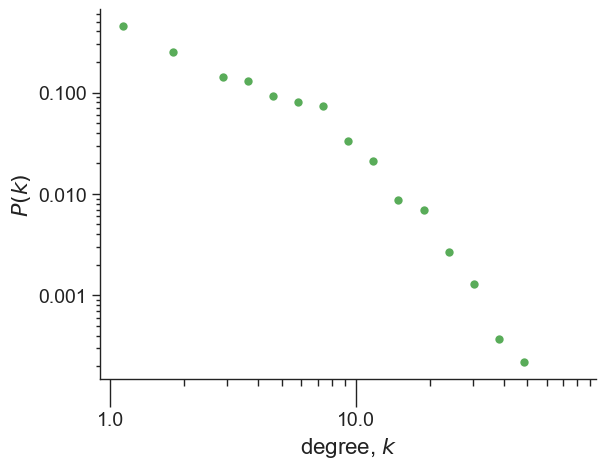

In [74]:
ax = plt.subplot(111)

plot_deg_dist(G_nonDev_top5, bins[1000], colors[1000], False)
plt.legend(frameon=False, numpoints=1)
plt.xlabel(r"degree, $k$")
plt.ylabel(r"$P(k)$")
despine()

# Customize the tick formatter for the x and y axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))


plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


gamma=  1.6493129012246344


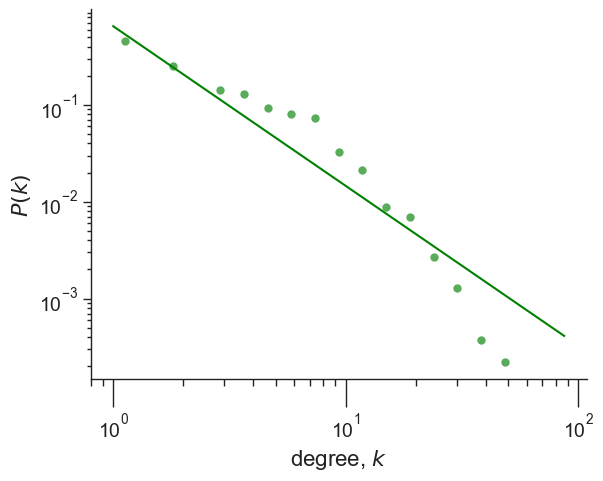

In [75]:
ax = plt.subplot(111)

plot_deg_dist_and_fit(G_nonDev_top5, bins[1000], colors[1000], False)
plt.legend(frameon=False, numpoints=1)
plt.xlabel(r"degree, $k$")
plt.ylabel(r"$P(k)$")
despine()

### Test Stability of the Subgraph

In [81]:
Average_ARI_Subgraph = stability_testing(G_nonDev_top5)
print(f"Average ARI: {Average_ARI_Subgraph}")

100%|██████████| 100/100 [00:04<00:00, 23.82it/s]

0.6843871812560777


### Obtain the Eigenvector Centrality Scores and Make a New Csv

In [ ]:
eig_whole = nx.eigenvector_centrality(G_nonDev, max_iter=100, tol=1e-06, nstart=None, weight=None)

eig_whole_sort = dict(sorted(eig_whole.items(), key=lambda item: item[1], reverse=True))

df_unweighted["eigenvalue"] = df_unweighted["label"].map(eig_whole)

df_unweighted.to_csv("Project_Data/nonDevDepNodeListCommunityUnweightedEigen.csv", index=False, sep='\t')

In [91]:
eig_whole = nx.eigenvector_centrality(G_nonDev, max_iter=100, tol=1e-06, nstart=None, weight="weight")

eig_whole_sort = dict(sorted(eig_whole.items(), key=lambda item: item[1], reverse=True))

df_weighted["eigenvalue"] = df_weighted["label"].map(eig_whole)

df_weighted.to_csv("Project_Data/nonDevDepNodeListCommunityWeightedEigen.csv", index=False, sep='\t')

In [92]:
print(G_nonDev)

Graph with 5043 nodes and 24135 edges
